In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 34.0 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 186 kB 45.2 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 306 kB/s 


In [ ]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
#hide
Path.BASE_PATH = path
print(path)

/root/.fastai/data/oxford-iiit-pet


In [ ]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [ ]:
(path/"images").ls()

(#7393) [Path('images/Bombay_120.jpg'),Path('images/yorkshire_terrier_16.jpg'),Path('images/Ragdoll_60.jpg'),Path('images/great_pyrenees_138.jpg'),Path('images/keeshond_65.jpg'),Path('images/beagle_202.jpg'),Path('images/newfoundland_62.jpg'),Path('images/shiba_inu_81.jpg'),Path('images/staffordshire_bull_terrier_31.jpg'),Path('images/Siamese_122.jpg')...]

In [ ]:
fname = (path/"images").ls()[0]
fname

Path('images/Bombay_120.jpg')

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Bombay']

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


## Presizing

In [ ]:
im_url = 'https://api.timeforkids.com/wp-content/uploads/2017/08/161007011580_hero.jpg?w=1024'
download_url(im_url, 'images/grizzly.jpg')

Path('images/grizzly.jpg')

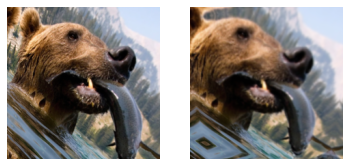

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

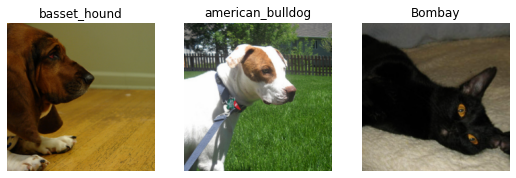

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/shiba_inu_92.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/shiba_inu_92.jpg
    applying partial gives
      shiba_inu
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(33))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: P

RuntimeError: ignored

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.538635,0.329424,0.107578,02:03


epoch,train_loss,valid_loss,error_rate,time
0,0.499946,0.312332,0.103518,02:39
1,0.341377,0.232261,0.076455,02:40


## Cross-Entropy Loss

### Viewing Activations and Labels

In [ ]:
x,y = dls.one_batch()

In [ ]:
y.shape, y

(torch.Size([64]),
 TensorCategory([33, 30, 15, 34, 12,  4, 19, 10,  5,  9,  3,  3,  3,  1,  7,  7, 26, 30, 19, 17, 19, 26,  8, 28, 16,  2,  1, 30, 30,  3, 21, 15, 32, 29, 31, 28, 17, 28, 21, 12, 18, 12,  6, 16, 32,  1, 14, 36,
         26, 21,  1, 30, 24, 35, 30, 21,  0,  1, 29, 33, 34, 36, 24, 35], device='cuda:0'))

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([3.5159e-06, 3.3662e-07, 2.5401e-07, 2.7980e-06, 8.2304e-07, 1.1387e-07, 1.1971e-06, 3.4193e-07, 1.3161e-06, 7.0468e-07, 5.4459e-07, 4.0426e-08, 9.4832e-07, 4.5057e-06, 5.6068e-07, 1.2867e-05,
        3.2580e-06, 1.3054e-06, 1.5496e-07, 8.5094e-08, 4.7705e-07, 1.5191e-06, 1.7109e-06, 8.3424e-07, 1.6241e-06, 2.1065e-06, 5.6251e-07, 1.0787e-07, 9.4736e-06, 1.2176e-06, 1.5158e-06, 8.3610e-05,
        1.7595e-06, 9.9983e-01, 1.5840e-05, 7.0826e-06, 1.5354e-06])

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Softmax

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


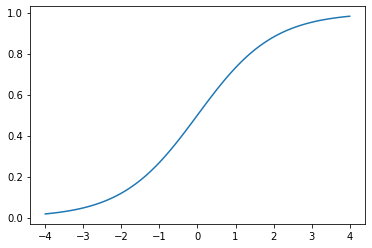

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ)

tensor(-0.3345)

In [ ]:
-sm_acts[idx, targ].mean()

tensor(-0.3345)

### Taking the Log

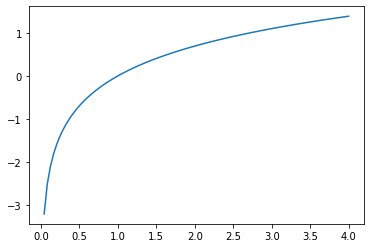

In [ ]:
plot_function(torch.log, min=0,max=4)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [ ]:
-sm_acts[idx, targ].log()

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

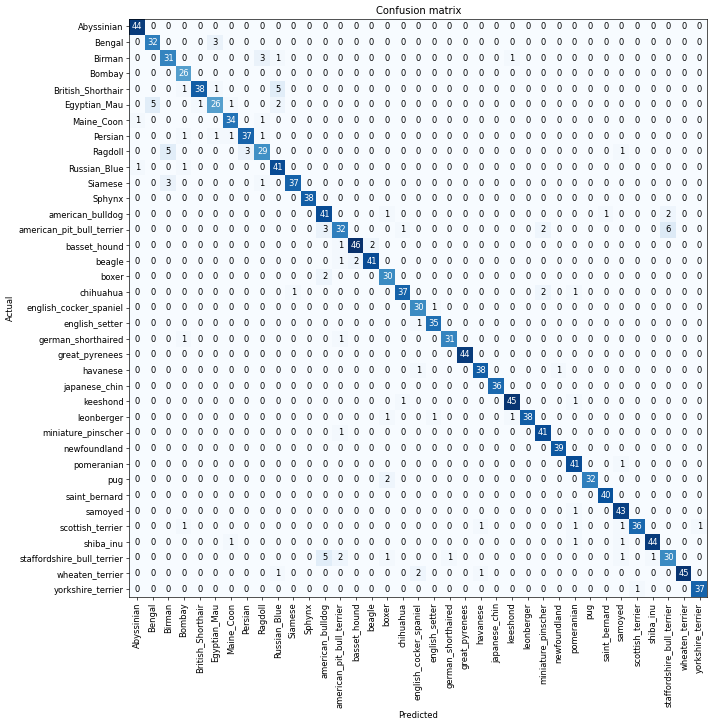

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5)]

## Improving Our Model

### The Learning Rate Finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.567521,4.615897,0.456698,02:02


epoch,train_loss,valid_loss,error_rate,time
0,3.786226,3.758791,0.645467,02:38


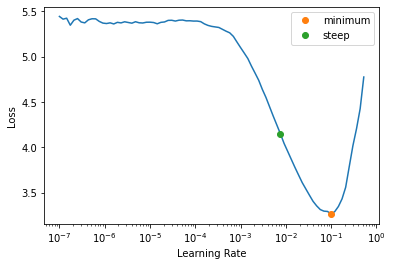

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 7.59e-03


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.300355,0.339569,0.115697,02:03


epoch,train_loss,valid_loss,error_rate,time
0,0.541095,0.422482,0.125846,02:40
1,0.331898,0.210918,0.066306,02:39


### Unfreezing and Transfer Learning

In [ ]:
learn.fine_tune??

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.100634,0.320939,0.095399,02:03
1,0.515850,0.243340,0.076455,02:03
2,0.338093,0.209245,0.064276,02:02


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=6.30957365501672e-05)

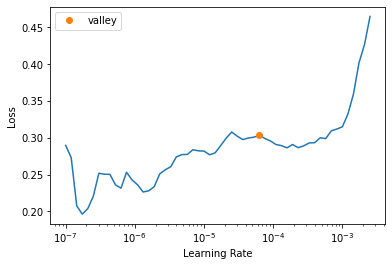

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.269193,0.199902,0.062246,02:39
1,0.263360,0.186983,0.056834,02:39
2,0.223857,0.185527,0.056834,02:38
3,0.190553,0.181704,0.055480,02:38
4,0.186751,0.184204,0.055480,02:38
5,0.172476,0.179914,0.056157,02:38


### Discriminative Learning Rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.144123,0.355618,0.104195,02:03
1,0.527892,0.251852,0.086604,02:04
2,0.324841,0.213789,0.069012,02:02


epoch,train_loss,valid_loss,error_rate,time
0,0.263363,0.210866,0.070365,02:39
1,0.251135,0.200701,0.063599,02:39
2,0.221608,0.193124,0.064276,02:39
3,0.213705,0.186667,0.060893,02:39
4,0.186218,0.183421,0.058187,02:39
5,0.179427,0.174984,0.060893,02:40
6,0.165269,0.173750,0.056157,02:39
7,0.154905,0.174454,0.056834,02:39
8,0.131184,0.173855,0.055480,02:40
9,0.130641,0.166194,0.053451,02:39


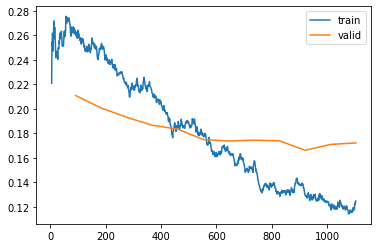

In [ ]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.282708,0.259717,0.084574,02:31
1,0.575468,0.254089,0.089310,02:31
2,0.409411,0.283179,0.088633,02:32


epoch,train_loss,valid_loss,error_rate,time
0,0.254505,0.219219,0.067659,03:21
1,0.312661,0.362032,0.104195,03:18
2,0.245575,0.246791,0.072395,03:18
3,0.153118,0.210315,0.066982,03:18
4,0.091941,0.174935,0.050068,03:17
5,0.060440,0.172379,0.050068,03:17


## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
> First, we resize the images one by one, sequentially, to ensure they have a uniform size, in order to be able to collate them in batches. Once we have batches of images, it's possible to perform data augmentation and resizing on the GPU, which is a lot faster than using the CPU. This two-step process is necessary to use the fastai presizing method.

1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.

1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
> Individual files in a hierarchy of folders:
> ```
> .
> ├── train
> │    ├── class_1
> │    │    ├── example_1
> │    │    ├── ...
> │    │    └── example_1
> │    ├── ...
> │    └── class_n
> │
> └── valid
>      └── ...
> ```
> Or tabular data, like CSV files, where each row is an item.

1. Look up the documentation for `L` and try 
using a few of the new methods that it adds.
> ``` python
> > l = L((torch.rand(20)*10).int().tolist())
> > l
> (20) [6,7,9,9,1,6,2,4,1,9...]
> > l.unique(sort=True)
> (8) [0,1,2,4,5,6,7,9]
> > l.filter(lambda x: x%2 == 0)
> (9) [6,6,2,4,6,6,2,6,0]
> > l.map(lambda x: x**2)
> (20) [36,49,81,81,1,36,4,16,1,81...]
> > l.zipwith((1,2,3,4,5))
> (5) [(6, 1),(7, 2),(9, 3),(9, 4),(1, 5)]
> ```

1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
> ``` python
> > Path.cwd(), Path.home()
> (Path('/content'), Path('/root'))
> > p = Path.cwd()/'sample_data'
> > p.exists(), p.is_dir(), p.is_file(), p.owner()
> (True, True, False, 'root')
> > (p/'asdklfjañls').exists()
> False
> ```

1. Give two examples of ways that image transformations can degrade the quality of the data.
> Many common image transformations can degradee the quality of the data. For instance, rotating an image or zooming introduces empty zones that must be filled by pixel interpolation.

1. What method does fastai provide to view the data in a `DataLoaders`?
> `DataLoaders.show_batch`

1. What method does fastai provide to help you debug a `DataBlock`?
> `DataBlock.summary()`

1. Should you hold off on training a model until you have thoroughly cleaned your data?
> No, a better aproach is to train a model as soon as possible, as it will help you clean up the data.

1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
> (Softmax + log) + negative log likelihood (nll) loss

1. What are the two properties of activations that softmax ensures? Why is this important?
> Softmax ensures that the output values will be between 0 and 1, and will sum 1. Additionaly, it amplifies small changes between input values.

1. When might you want your activations to not have these two properties?
> When you are solving regression or multi-label classification problems.

1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).

1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
> `torch.where` can be used as a if-else statment, but having more than two categories would require nested `torch.where` calls, which is not easily scalable.

1. What is the value of log(-2)? Why?
> `log(-2) = 0.301029996 + 1.36437635i`, which is an imaginary number because log function is defined in range (0, +inf] (not includes -2).

1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
> - To pick a value of one order of magnitude less than where the minimum loss was achived.
> - To pick the las point where loss was decreasing.

1. What two steps does the `fine_tune` method do?
> 1. Freezes all layers except the last one (the head), training it (for a single epoch by default).
> 1. Unfreezes the entire neural net and trains it for the specified number of epochs.

1. In Jupyter Notebook, how do you get the source code for a method or function?
> Using `??` after a function: `function??`.

1. What are discriminative learning rates?
> Discriminative learning rates is a training technique that consist of using higher learning rates as we go deeper into the neural network. Early layers learn the foundations (e.g. detecting lines and simple patterns in CNNs), which are likely to be useful for the problem we are fine tuning, and so we dont need to modifiy them abruptly.
Later layers are more specialized in detection of complex patterns (representing objects or parts of objects) that are present in the problem the neural network was trained for, so we want to modify their parameters to adapt them for the problem we are fine tuning.

1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
> When you pass a `slice(x, y)` object to fastai you are setting the first layer lr to $x$ and the last to $y$ (assuming that $x < y$). The middel layers will take equidistant lrs between $x$ and $y$.

1. Why is early stopping a poor choice when using 1cycle training?
> Because training may not have had time to reach the lower learning rate values, which could improve the model. A better aproach is to retrain the model from scratch, setting the number of epochs based on where the best results were found.

1. What is the difference between `resnet50` and `resnet101`?
> `resnet50` has 50 layers, while `resnet101` has 101.

1. What does `to_fp16` do?
> Makes the learner to use _half-precision floating point_ (i.e. _floats_ of 16 bits insted of 32), which speeds up the training process.


### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.